**Importing the required libraries**

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, max_error
from time import time
import warnings
import joblib

**Loading the dataset**

**Dataset (CO2 Emission by Vehicles) was [downloaded](https://www.kaggle.com/datasets/debajyotipodder/co2-emission-by-vehicles?select=CO2+Emissions_Canada.csv)**

In [3]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/CO2/CO2 Emissions_Canada.csv')

Mounted at /content/drive


**Define a function for basic information of the dataset**

In [ ]:
def basic_desc(data):
    print('Short overview of data\n================================================\n')
    data.info()

    print('Statistical overview of data\n================================================\n')
    data.describe(include='all')

    print('Checking for duplicates\n================================================\n')
    if data.duplicated().any():
        print(f'{data.duplicated().sum()} duplicates found in "{data[data.duplicated()]}"\n')
    else:
        print('No duplicates found\n')

    print('Checking for missing values\n================================================\n')
    if not data.isna().any:
        try:
            data.isna().sum()
            print(f'\nMissing values found in column "{data.loc[:, data.isnull().any()].columns[0]}"\n')
        except IndexError:
            print('\nNo missing values found\n')
    else:
        print('\nNo missing values found\n')

In [13]:
basic_desc(df)

Short overview of data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Make                              7385 non-null   object 
 1   Model                             7385 non-null   object 
 2   Vehicle Class                     7385 non-null   object 
 3   Engine Size(L)                    7385 non-null   float64
 4   Cylinders                         7385 non-null   int64  
 5   Transmission                      7385 non-null   object 
 6   Fuel Type                         7385 non-null   object 
 7   Fuel Consumption City (L/100 km)  7385 non-null   float64
 8   Fuel Consumption Hwy (L/100 km)   7385 non-null   float64
 9   Fuel Consumption Comb (L/100 km)  7385 non-null   float64
 10  Fuel Consumption Comb (mpg)       7385 non-null   int64  
 11  CO2 Emissions(g/km)               7385 non-nu

**Overall the data looks clean**     
**There are some car models, cylinders, transmissions and fuel duplicates but they differ in terms of fuel consumption.**

**Define a function which plots the numerical information**

In [14]:
def plot_numeric_dist(data, target):
    numeric_features = data.select_dtypes(include=[np.number])
    print('\nShort overview of data\n================================================\n')
    numeric_features.info()
    print('\nStatistical overview of data\n================================================\n')
    numeric_features.describe()
    plt.figure(figsize=(20, 7))
    for col in numeric_features.columns:
        if len(data[col].unique()) > 70:
            f = plt.figure(figsize=(20, 10))
            f.add_subplot(2, 1, 1)
            sns.scatterplot(x=data[col], y=data[target])
            plt.xticks(rotation=90)
            f.add_subplot(2, 1, 2)
            sns.kdeplot(x=data[col])
        else:
            f = plt.figure(figsize=(20, 7))
            f.add_subplot(2, 1, 1)
            sns.boxplot(x=data[col], y=data[target])
            plt.xticks(rotation=90)
            f.add_subplot(2, 1, 2)
            sns.kdeplot(x=data[col])
    plt.figure(figsize=(20, 10))
    correlation = numeric_features.corr()
    sns.heatmap(correlation, square=True, annot=True)


Short overview of data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 7 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Engine Size(L)                    7385 non-null   float64
 1   Cylinders                         7385 non-null   int64  
 2   Fuel Consumption City (L/100 km)  7385 non-null   float64
 3   Fuel Consumption Hwy (L/100 km)   7385 non-null   float64
 4   Fuel Consumption Comb (L/100 km)  7385 non-null   float64
 5   Fuel Consumption Comb (mpg)       7385 non-null   int64  
 6   CO2 Emissions(g/km)               7385 non-null   int64  
dtypes: float64(4), int64(3)
memory usage: 404.0 KB

Statistical overview of data



<Figure size 1440x504 with 0 Axes>

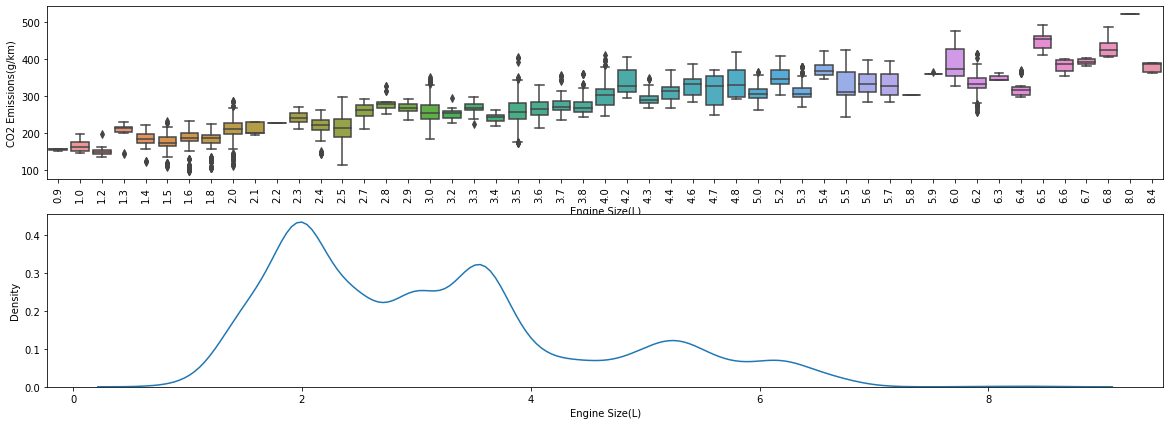

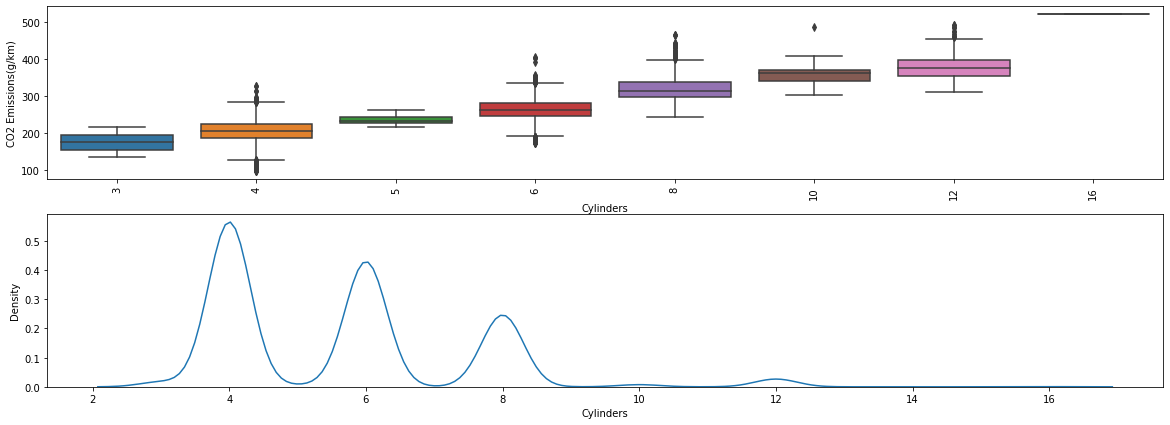

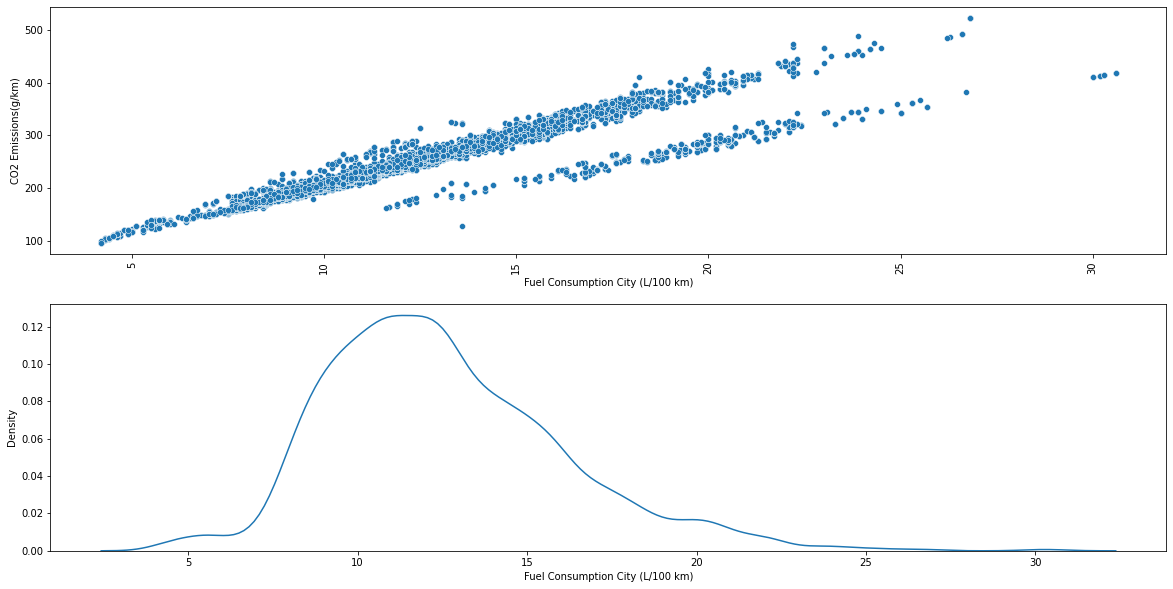

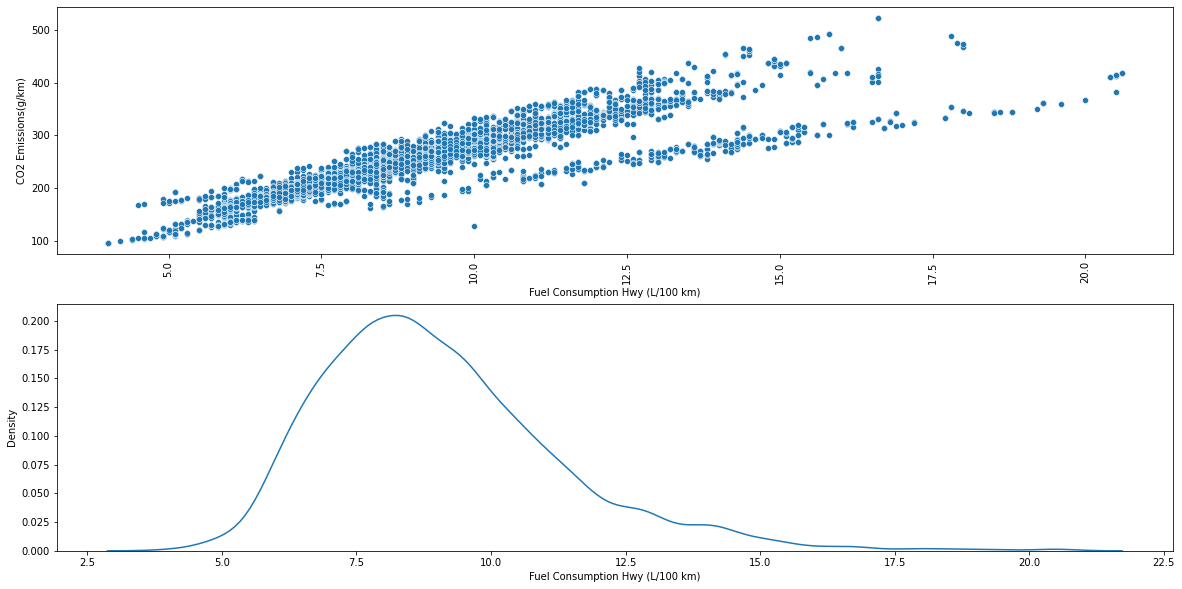

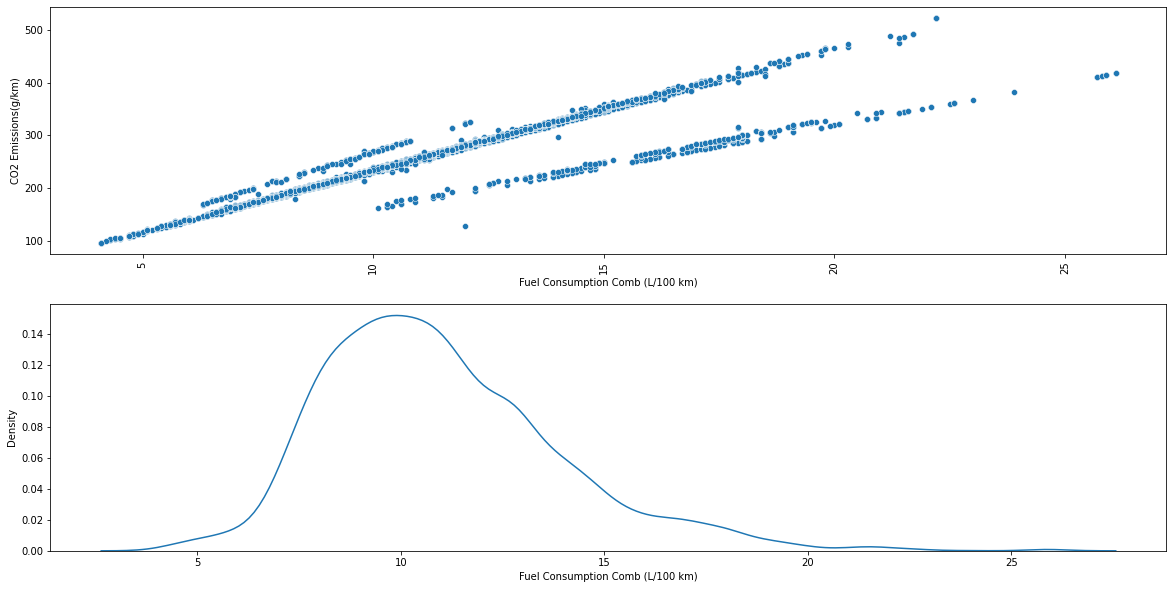

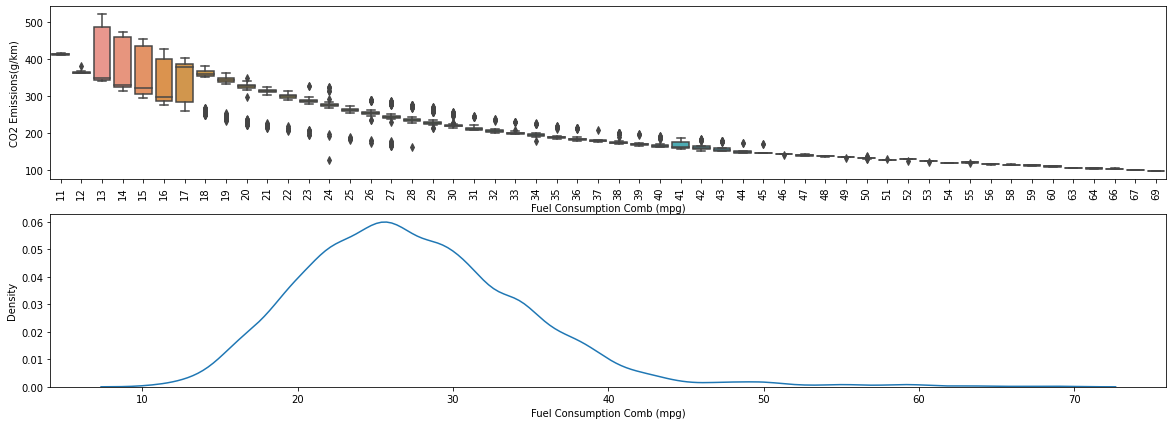

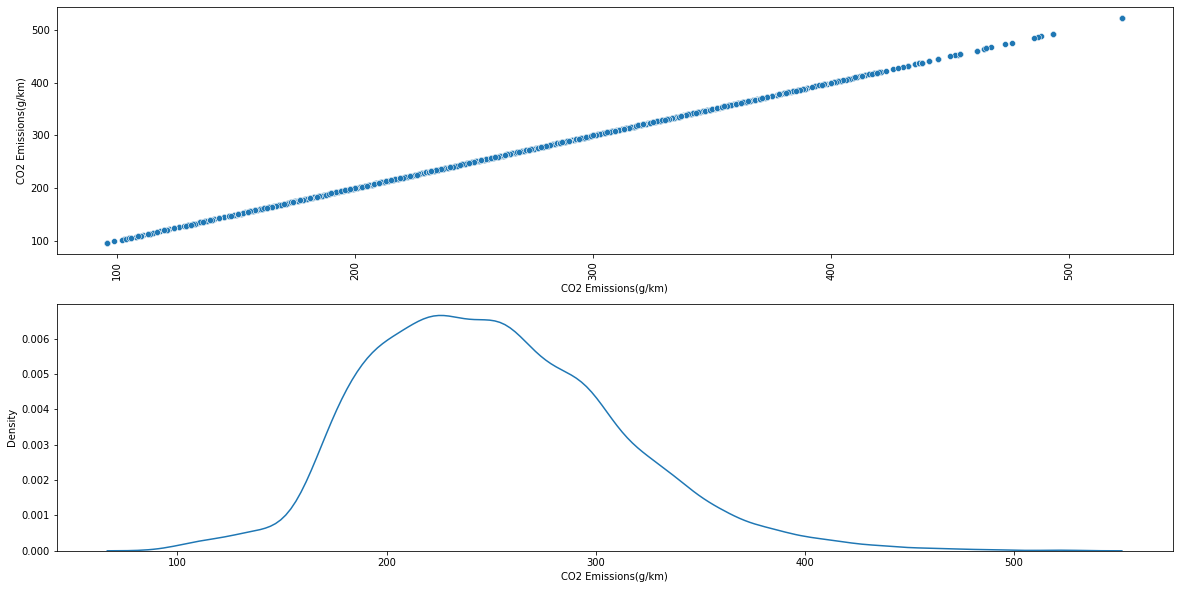

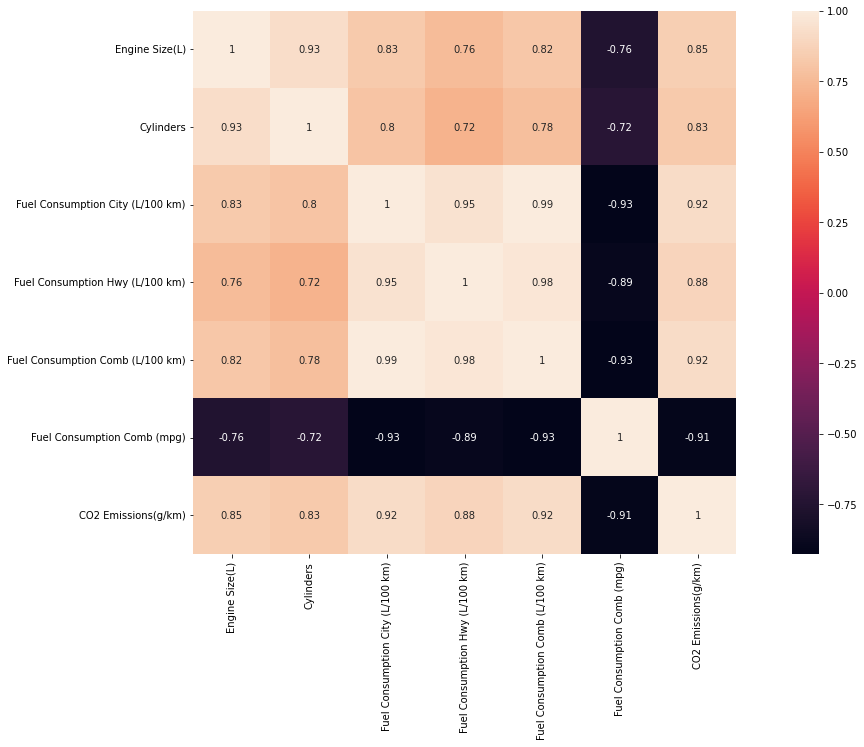

In [15]:
plot_numeric_dist(df, 'CO2 Emissions(g/km)')

**The dataset has clear associations between the mechanical characteristics and fuel consumption vs CO2 Emissions**    
**Let's see the trends for categorical variables**

**Define a function which plots the categorical information**

In [19]:
def plot_categ_dist(data, target):
    categorical_features = data.select_dtypes(exclude=[np.number])
    print('\nShort overview of data\n================================================\n')
    print(categorical_features.info())
    print('\nStatistical overview of data\n================================================\n')
    print(categorical_features.describe())
    for col in categorical_features.columns:
        if len(categorical_features[col].unique()) > 70:
            print(f'\nDistribution of {col} column\n================================================\n')
            print(categorical_features[col].describe())
        else:
            f = plt.figure(figsize=(20, 7))
            f.add_subplot(2, 1, 1)
            sns.boxplot(x=categorical_features[col], y=data[target])
            plt.xticks(rotation=90)


Short overview of data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Make           7385 non-null   object
 1   Model          7385 non-null   object
 2   Vehicle Class  7385 non-null   object
 3   Transmission   7385 non-null   object
 4   Fuel Type      7385 non-null   object
dtypes: object(5)
memory usage: 288.6+ KB
None

Statistical overview of data

        Make          Model Vehicle Class Transmission Fuel Type
count   7385           7385          7385         7385      7385
unique    42           2053            16           27         5
top     FORD  F-150 FFV 4X4   SUV - SMALL          AS6         X
freq     628             32          1217         1324      3637

Distribution of Model column

count              7385
unique             2053
top       F-150 FFV 4X4
freq                 32
Name: Model, dtype: object


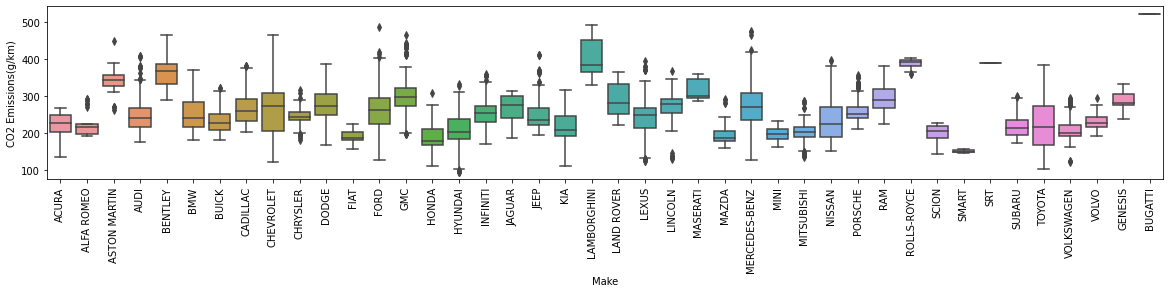

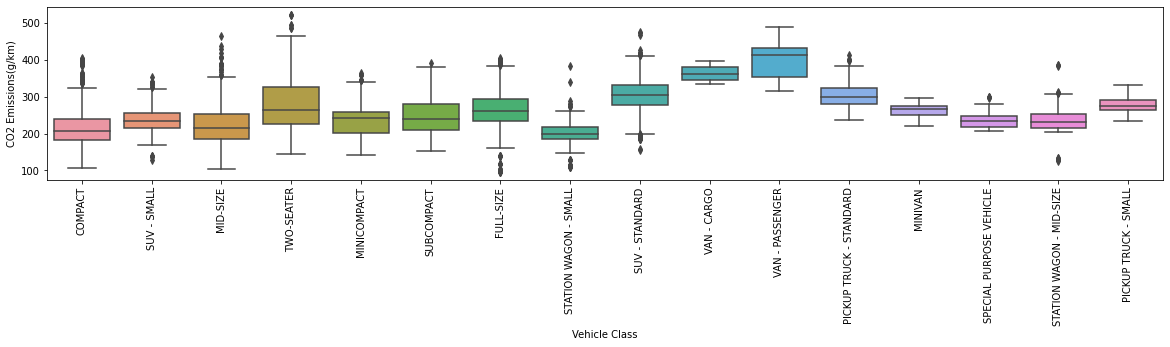

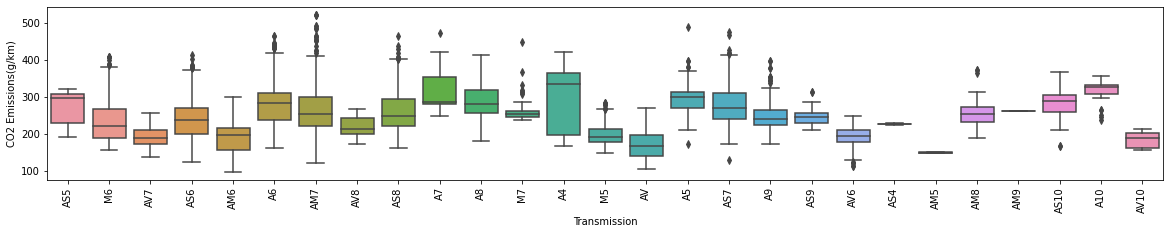

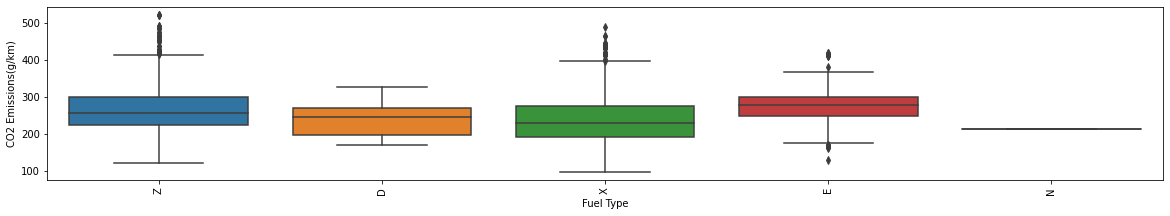

In [20]:
plot_categ_dist(df, 'CO2 Emissions(g/km)')

**The Model has way too many values to be plotted while the Make column shows that only super cars have the most impact over CO2, therefore these features might influence the bias**    

**Vehicle Class, Transmission and Fuel Type are much better features to be used since the categories do not discriminate (eg. there are cars that are not in the super cars category yet they might have the same type of transmission etc)**

**Define a function which encodes categorical information to the their unique index value**

In [21]:
def label_enc(features):
    return dict([(feature, value) for feature, value in zip(features.unique(), range(len(features.unique())))])

**Encode selected categorical features**

In [22]:
df['Transmission'].replace(label_enc(df['Transmission']), inplace=True)
df['Vehicle Class'].replace(label_enc(df['Vehicle Class']), inplace=True)
df['Fuel Type'].replace(label_enc(df['Fuel Type']), inplace=True)

**Replot all the numerical values and check the correlation with the newly added features.**


Short overview of data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Vehicle Class                     7385 non-null   int64  
 1   Engine Size(L)                    7385 non-null   float64
 2   Cylinders                         7385 non-null   int64  
 3   Transmission                      7385 non-null   int64  
 4   Fuel Type                         7385 non-null   int64  
 5   Fuel Consumption City (L/100 km)  7385 non-null   float64
 6   Fuel Consumption Hwy (L/100 km)   7385 non-null   float64
 7   Fuel Consumption Comb (L/100 km)  7385 non-null   float64
 8   Fuel Consumption Comb (mpg)       7385 non-null   int64  
 9   CO2 Emissions(g/km)               7385 non-null   int64  
dtypes: float64(4), int64(6)
memory usage: 577.1 KB

Statistical overview of data



<Figure size 1440x504 with 0 Axes>

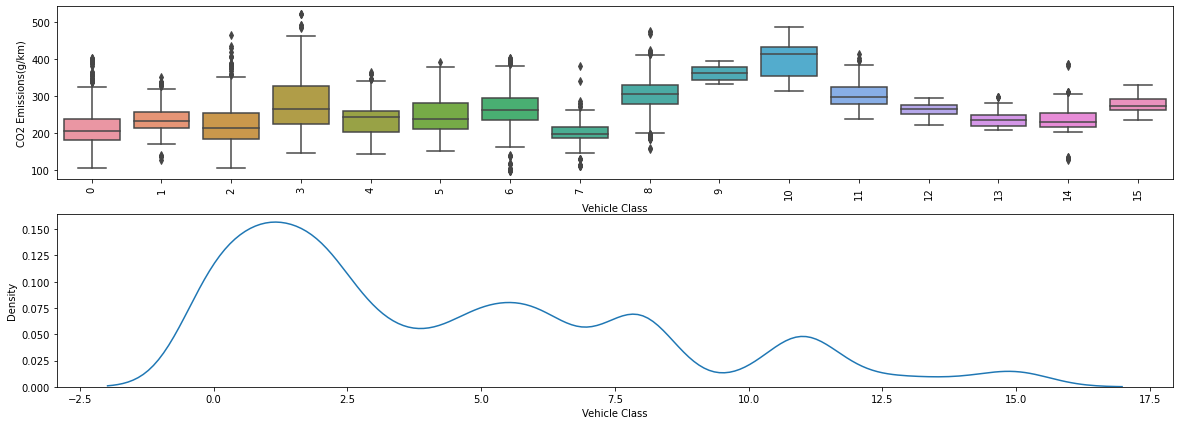

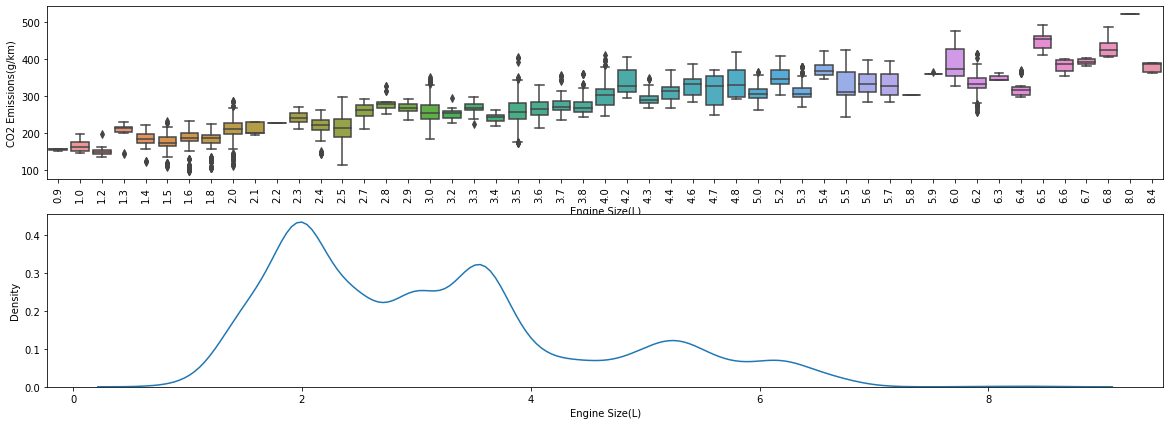

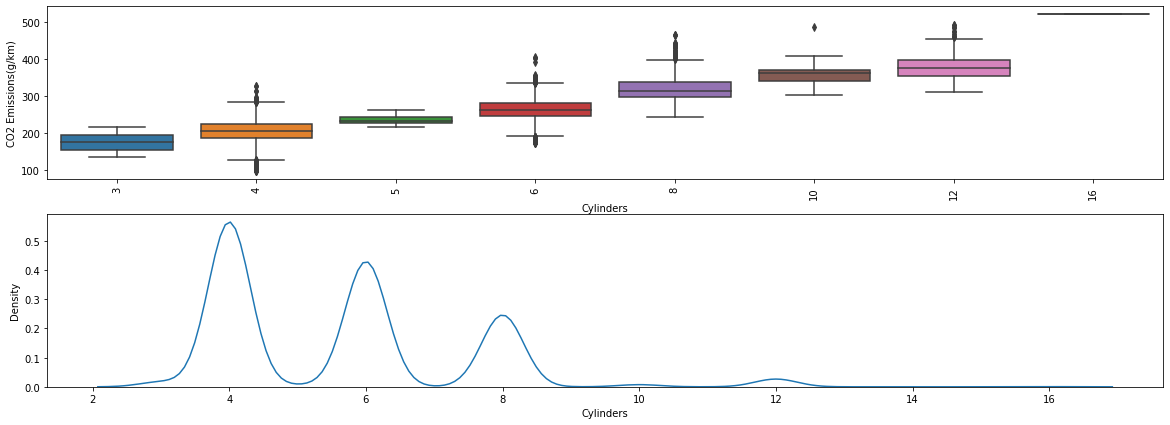

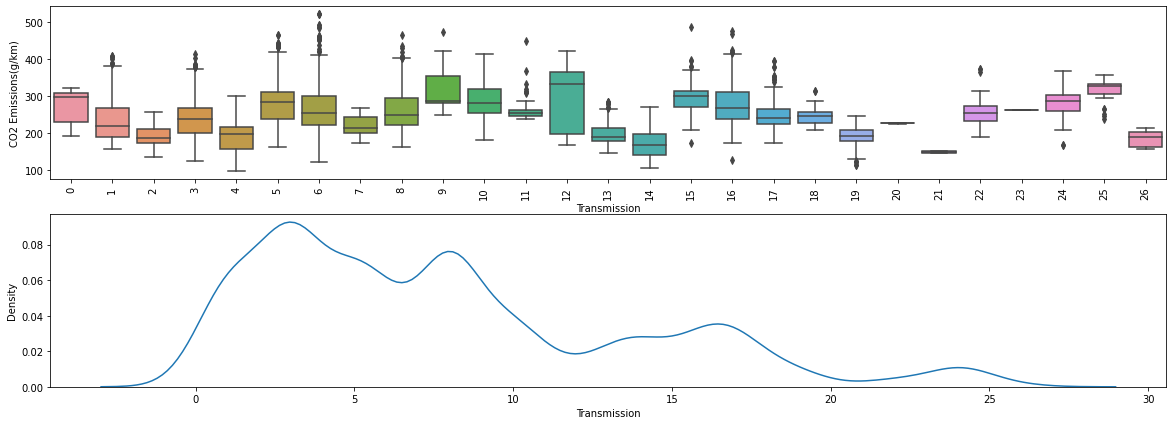

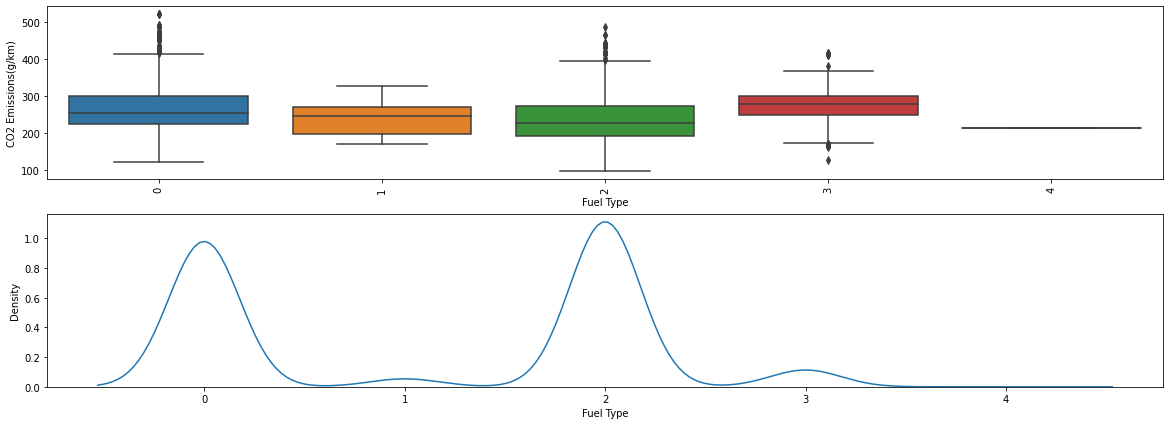

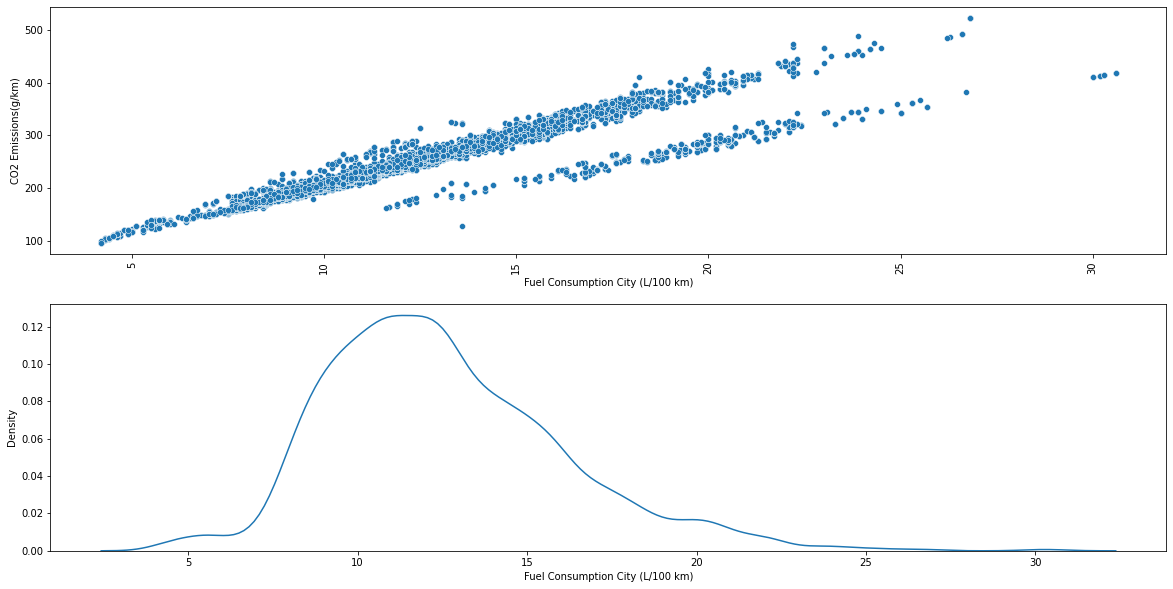

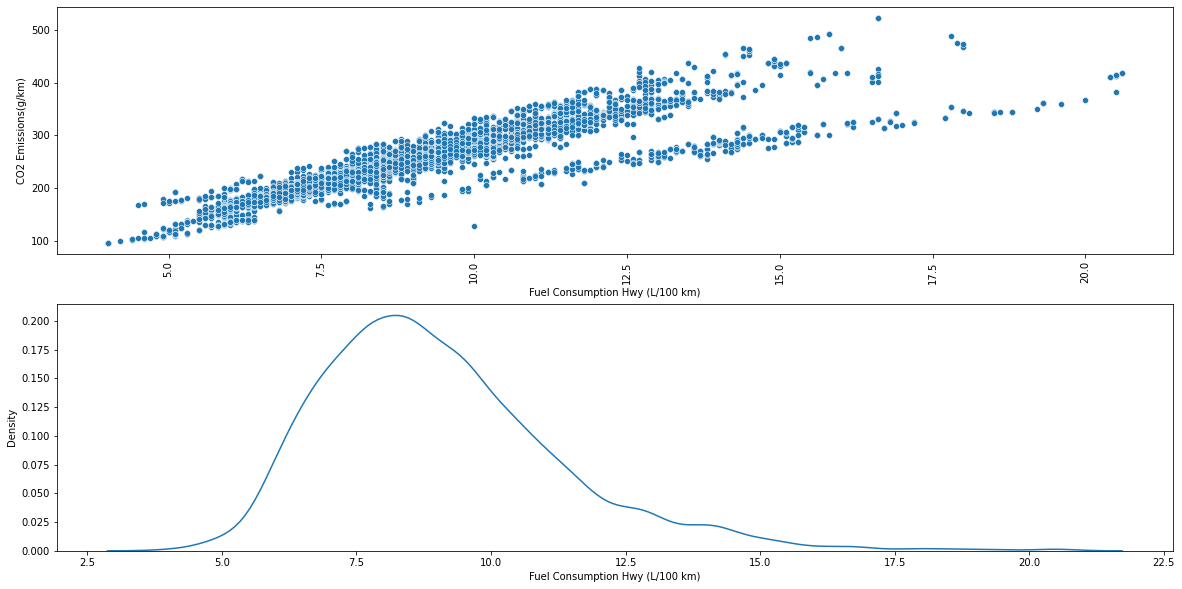

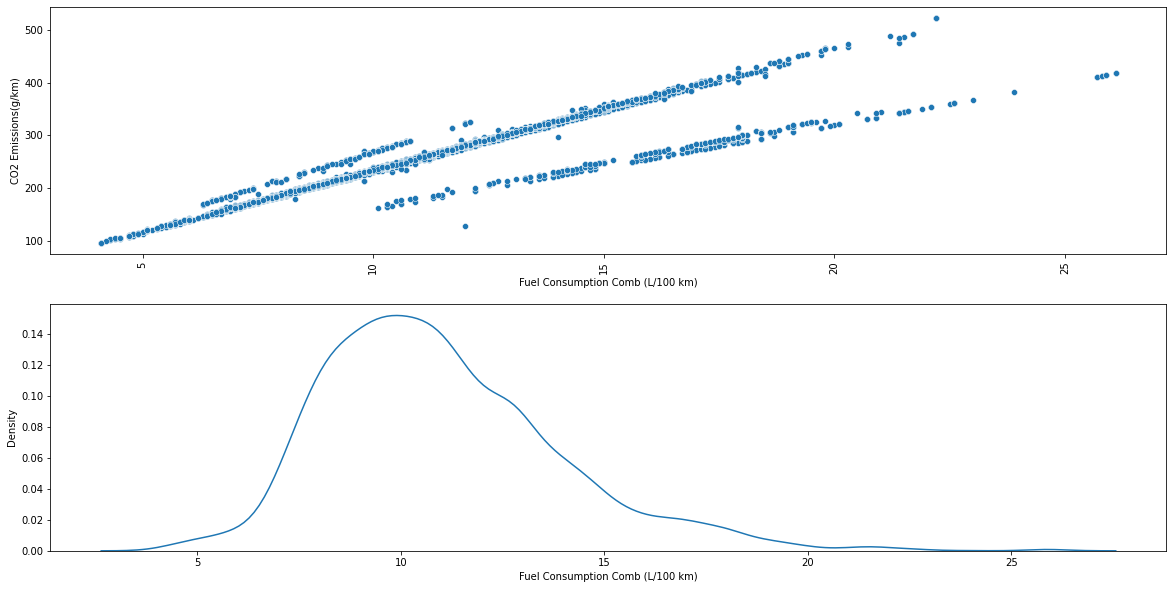

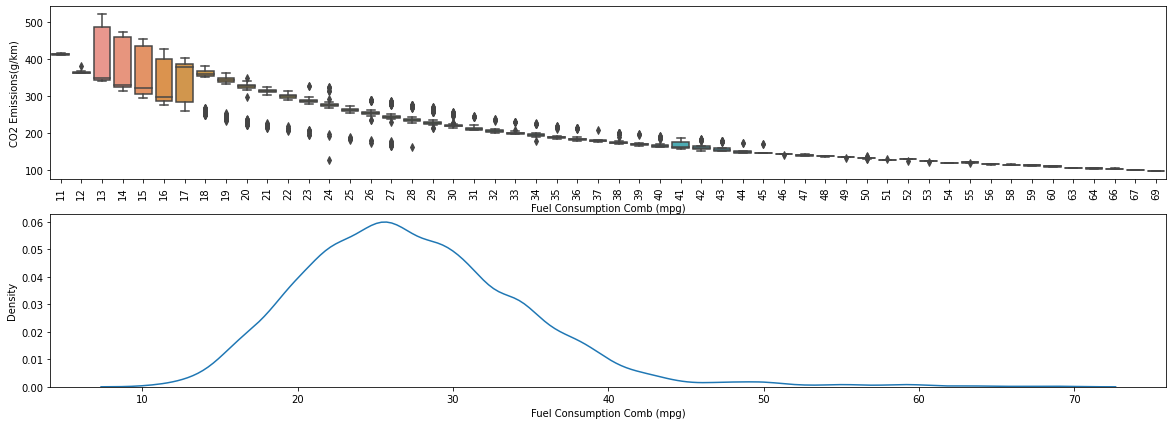

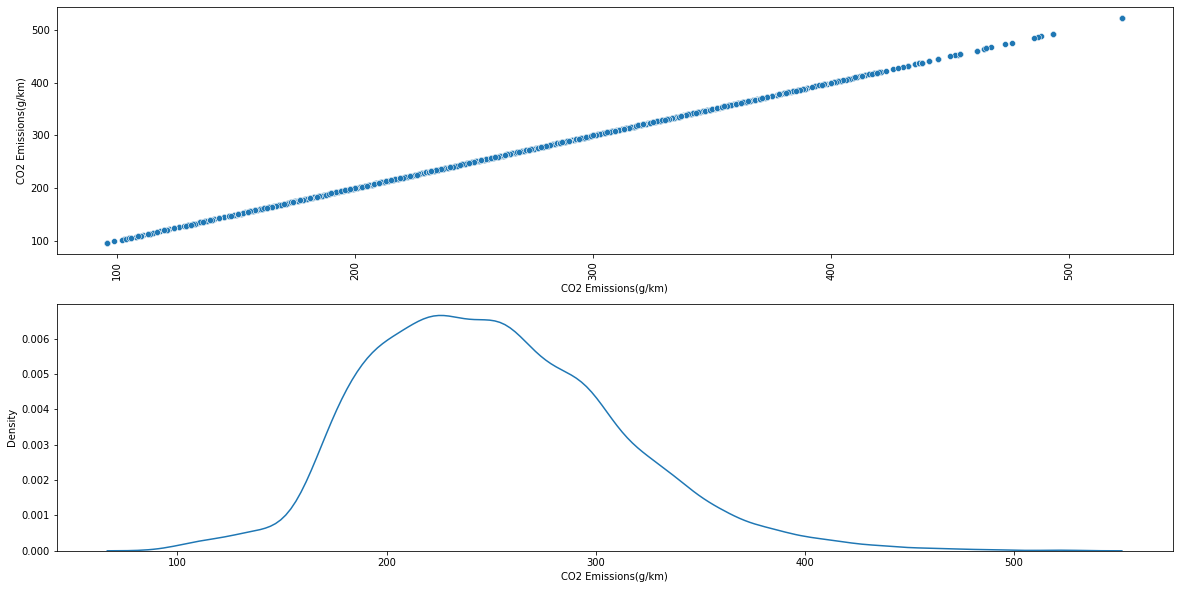

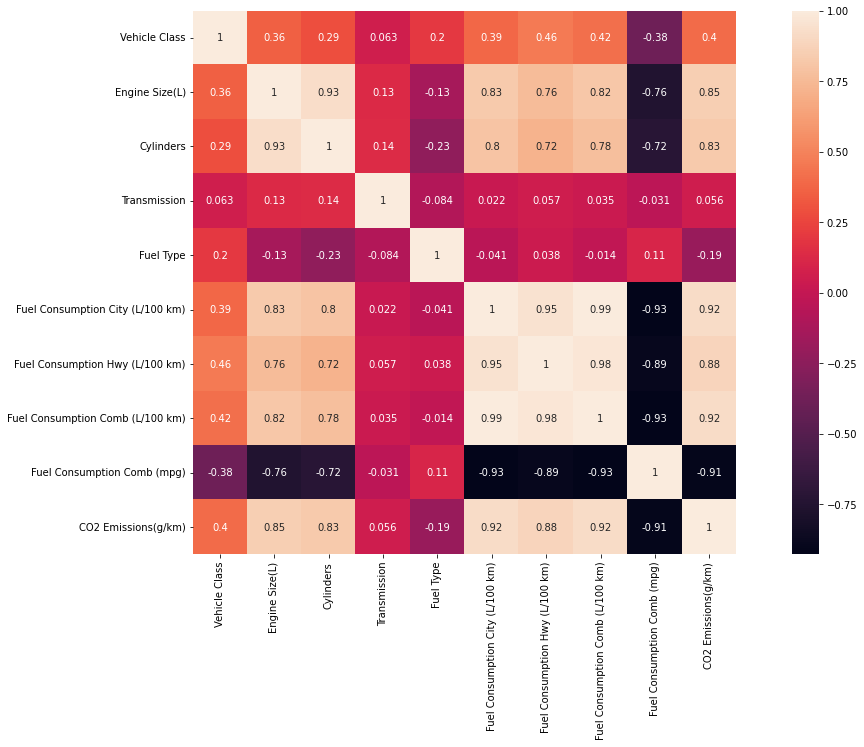

In [23]:
plot_numeric_dist(df, 'CO2 Emissions(g/km)')

**The newly added numerical features do not seem to highlight strong correlations but they will be kept since fuel consumption features tend to have high correlations and might introduce a bias in the dataset**

**Transform and define X and y train and test set     
MinMaxScaler is gonna be used since StandardScaler expects a dataset with normal distribution and QuantileTransformer will create a plateau-shaped distribution**

In [24]:
scaler = MinMaxScaler()

y = df['CO2 Emissions(g/km)']

numeric_features = df.select_dtypes(include=[np.number])
numeric_features = numeric_features.drop(['CO2 Emissions(g/km)'], axis=1)

X = scaler.fit_transform(numeric_features.values)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=1, shuffle=True)

**Define a function for metrics retrieval**

In [26]:
def print_results(results, mdl):
    print('BEST PARAMS FOR {} : {}\n'.format(str(mdl).replace('()', ''), results.best_params_))
    print('BEST ACCURACY FOR {0} : {1:.2f}\n'.format(str(mdl).replace('()', ''), results.best_score_))
    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

**Define a function for model evaluation**

In [1]:
def evaluate_model(name, model, features, labels):
    start = time()
    prediction = model.predict(features)
    end = time()
    det_coef = round(r2_score(labels, prediction), 3)
    mse = round(mean_squared_error(labels, prediction, squared=False), 3)
    mae = round(mean_absolute_error(labels, prediction), 3)
    merr = round(max_error(labels, prediction), 3)
    print(f'{name} evaluation: R2 score: {det_coef}, MSE score: {mse}, MAE score: {mae}, Max Residual Error: {merr}, Latency: {round((end - start)*1000, 1)}\n')

**Create a list of algorithms to be used for this regression problem and a list of dicts containing the hyperparameters to be tunned with GridSearchCV**    
**For the sake of speed, Linear Regression, Linear SVR and SVR are gonna be used while algorithms such as RandomForestRegressor, GradientBoostingRegressor or a Neural Network might take a long time to train**

In [4]:
mdls = LinearRegression(), LinearSVR(), SVR()

lr_parameters = {
    'fit_intercept': [False, True],
    'copy_X': [True]
}

lsvr_parameters = {
    'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'fit_intercept': [True, False],
    'dual': [True, False],
    'random_state': [1]
}

svr_parameters = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'shrinking': [True, False]
}

params = [lr_parameters, lsvr_parameters, svr_parameters]

**Defining the loops for 5-fold cross validation training**

In [30]:
warnings.filterwarnings("ignore")

if len(mdls) == len(params):
    for mdl, param in zip(mdls, params):
        print(f'Training {mdl} model..')
        start = time()
        cv = GridSearchCV(mdl, param, cv=5)
        cv.fit(X_train, y_train.values.ravel())
        end = time()
        print('\nTraining took: {0:.3} minutes\n'.format((end-start)/60))
        print_results(cv, mdl)
        joblib.dump(cv.best_estimator_, f'{str(mdl).replace("()","")}_model.pkl')
else:
    print(f'\nParameters nr.: {len(params)}\n Algorithms nr.: {len(mdls)}\n')

Training LinearRegression() model..

Training took: 0.000487 minutes

BEST PARAMS FOR LinearRegression : {'copy_X': True, 'fit_intercept': True}

BEST ACCURACY FOR LinearRegression : 0.91

0.814 (+/-0.05) for {'copy_X': True, 'fit_intercept': False}
0.906 (+/-0.017) for {'copy_X': True, 'fit_intercept': True}
Training LinearSVR() model..

Training took: 0.0429 minutes

BEST PARAMS FOR LinearSVR : {'C': 10, 'dual': True, 'fit_intercept': True, 'loss': 'squared_epsilon_insensitive', 'random_state': 1}

BEST ACCURACY FOR LinearSVR : 0.91

-19.062 (+/-3.085) for {'C': 0.001, 'dual': True, 'fit_intercept': True, 'loss': 'epsilon_insensitive', 'random_state': 1}
0.296 (+/-0.057) for {'C': 0.001, 'dual': True, 'fit_intercept': True, 'loss': 'squared_epsilon_insensitive', 'random_state': 1}
-19.334 (+/-3.13) for {'C': 0.001, 'dual': True, 'fit_intercept': False, 'loss': 'epsilon_insensitive', 'random_state': 1}
-0.966 (+/-0.34) for {'C': 0.001, 'dual': True, 'fit_intercept': False, 'loss': 'sq

**Defining the loop for models loading**

In [32]:
models = {}

for mdl in ['LinearRegression', 'LinearSVR', 'SVR']:
    print(f'Loading {mdl}_model.pkl')
    models[mdl] = joblib.load(f'{mdl}_model.pkl')

Loading LinearRegression_model.pkl
Loading LinearSVR_model.pkl
Loading SVR_model.pkl


**Evaluating the models on the test set**

In [76]:
print(f'\nEvaluating models on the test dataset: \n')
for name, mdl in models.items():
    evaluate_model(name, mdl, X_test, y_test)


Evaluating models on the test dataset: 

LinearRegression evaluation: R2 score: 0.917, MSE score: 16.976, MAE score: 11.712, Max Residual Error: 89.238, Latency: 2.7

LinearSVR evaluation: R2 score: 0.917, MSE score: 16.969, MAE score: 11.716, Max Residual Error: 88.506, Latency: 1.2

SVR evaluation: R2 score: 0.996, MSE score: 3.833, MAE score: 2.258, Max Residual Error: 86.805, Latency: 757.8



**Finally SVR seems like the ideal algorithm for this kind of problem despite its downside of prediction time which can be easily traded for better accuracy depending on the situation**